<center><img src="../../logo.png" alt="drawing" width="400" style="background-color:white; padding:1em;" /></center> <br/>

# Application of Deep Learning to Text and Image Data
## Module 3, Lab 5: Using the ConvNeXt Model

This notebook explains how to import the ConvNeXt model and use it to make predictions on a small selection of example images.

You will learn how to do the following:

- Download the ConvNext pre-trained model
- Pre-process images
- Use ConvNext to perform inference on images

----

You will be presented with a challenge at the end of this lab:

| <img style="float: center;" src="../../challenge.png" alt="Challenge" width="125"/> |
| --- |
| <p style="text-align:center;">Challenges are where you can practice your coding skills.</p> |

---
## Index

- [Downloading a pretrained model](#Downloading-a-pretrained-model)
- [Preprocessing an image](#Preprocessing-an-image)
- [Inference using ConvNeXt](#Inference-using-ConvNeXt)

---
## Downloading a pretrained model

With Torchvision, you can use a ConvNeXt model that is trained on the ImageNet dataset as the base model. You will import the `convnext_tiny` model with the `IMAGENET1K_V1` weights. This model is the smallest size ConvNeXt model from its original implementation. Its weights are associated with the ImageNet dataset with 1K classes.

For more information about the `convnext_tiny` model, see [convnext_tiny](https://pytorch.org/vision/main/models/generated/torchvision.models.convnext_tiny.html) in the PyTorch documentation.

For information about other pretrained models, see [Models and Pre-trained Weights](https://pytorch.org/vision/stable/models.html) in the PyTorch documentation.

In [1]:
%%capture
# Install libraries
!pip install -U -q -r requirements.txt

In [2]:
import os, json
import matplotlib.pyplot as plt
import torch, torchvision
from PIL import Image
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import convnext_tiny

# Use GPU resource if available; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = convnext_tiny(weights="IMAGENET1K_V1").to(device)

Matplotlib is building the font cache; this may take a moment.
Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:02<00:00, 52.8MB/s] 


---
## Preprocessing an image

After importing the dataset, read a sample image and preprocess it with preset data transforms by using `transform_eval`.

The sample image is an American kitchen scene.

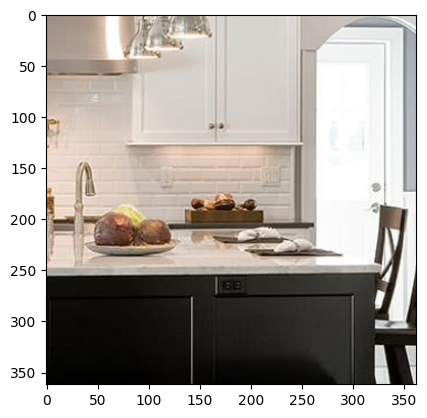

In [12]:
img_raw = Image.open('data/minc-2500/test/food/food_001611.jpg').convert('RGB')
plt.imshow(img_raw)
plt.show()

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
])

img_tr = transform(img_raw)

# calculate mean and std
mean, std = img_tr.mean([1,2]), img_tr.std([1,2])
print(mean)
print(std)

tensor([0.6043, 0.5748, 0.5465])
tensor([0.3435, 0.3366, 0.3347])


In [14]:
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

img = transform_eval(img_raw).to(device)

---
## Inference using ConvNeXt

Now that the sample image is imported and preprocessed, you will use the pretrained ConvNeXt model to predict the class for this image. You will use the `net` object that was defined in a previous cell to evaluate and generate predictions. Output will be saved to the `pred` variable, which will consist of a list of ndarrays, where each ndarray is of length 1,000.

Each number of this 1,000-length ndarray can have `softmax` applied to represent the prediction confidence toward each of the [subject classes in ImageNet](https://image-net.org/challenges/LSVRC/index.php).

In [15]:
net.eval()
pred = net(img.unsqueeze(0))

print("Number of classes as output")
print(len(pred[0]))

Number of classes as output
1000


PyTorch doesn't offer a built-in function to access all the existing classes of ImageNet. To see the existing classes, you need to load an external JSON list that has a mapping for the ImageNet classes to the indices. The dataset has 1,000 classes (therefore, the model weights are called `IMAGENET1K_V1`). Import and look at the first 5 classes.

In [16]:
with open("data/imagenet_idx_to_class.json", "r") as f:
    classes = json.load(f)

print(classes[:5])

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']


The first 5 classes don't have any relation to the sample image of a kitchen. Therefore, you will need to compare the list of model predictions (the `pred` variable) to the list of classes that you just imported. Let's see what the model thinks of the input test image.

The model made 1,000 predictions, but the further down the list the prediction is, the lower the probability of it being a correct prediction. For this reason, you only need to print the top 5 results (classes) that the model returns.

In [17]:
topK = 5
conf, ind = torch.topk(pred.squeeze(0), k=topK)
ind = ind.squeeze(0).cpu().numpy()
print('The input picture is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i]], torch.softmax(pred.squeeze(0), dim=0)[ind[i]].item()))

The input picture is classified to be
	[dining table], with probability 0.147.
	[window shade], with probability 0.106.
	[microwave], with probability 0.100.
	[plate rack], with probability 0.084.
	[stove], with probability 0.079.


The results are related to to kitchen items. Remember that the input was an image of a kitchen.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h3><i>Try it yourself!</i></h3>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../../challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Use the following code cell to make a prediction with another image.</p><br>
    <p style=" text-align: center; margin: auto;">Use the image <code>data/minc-2500/test/water/water_001765.jpg</code> and predict its class.</p><br>
</div>

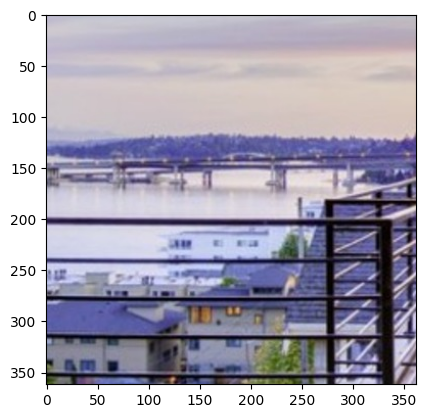

Image Mean: tensor([0.5884, 0.5702, 0.6498]) Image Std Dev: tensor([0.2428, 0.2340, 0.2156])
The input picture is classified to be
	[steel arch bridge], with probability 0.328.
	[lakeside], with probability 0.069.
	[pier], with probability 0.049.
	[seashore], with probability 0.028.
	[dam], with probability 0.018.


In [21]:
# Determine if a GPU is availible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set up the convnext_tiny model
challenge_net = convnext_tiny(weights="IMAGENET1K_V1").to(device)

############### CODE HERE ###############

challenge_img_raw = Image.open('data/minc-2500/test/water/water_001765.jpg').convert('RGB')
plt.imshow(challenge_img_raw)
plt.show()

transform = transforms.Compose([
    transforms.ToTensor()
])

challenge_img_tr = transform(challenge_img_raw)

# calculate mean and std
challenge_mean, challenge_std = challenge_img_tr.mean([1,2]), challenge_img_tr.std([1,2])
print("Image Mean:", challenge_mean, "Image Std Dev:", challenge_std)

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(challenge_mean, challenge_std)
])

challenge_img = transform_eval(challenge_img_raw).to(device)

challenge_net.eval()
pred = challenge_net(challenge_img.unsqueeze(0))

topK = 5
conf, ind = torch.topk(pred.squeeze(0), k=topK)
ind = ind.squeeze(0).cpu().numpy()
print('The input picture is classified to be')
for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i]], torch.softmax(pred.squeeze(0), dim=0)[ind[i]].item()))
############## END OF CODE ##############

---
## Conclusion

In this Lab, you saw how to import and use the ConvNeXt model to make predictions without training your own model. This is an easy and cost-effective way to get started with making predictions. The biggest problem is that the model probably won't fit well to your dataset, which means that you need to fine-tune the model to make good predictions.

--- 
## Next lab
In the next lab, you will learn how to fine-tune the ConvNeXt model to make better predictions that align with your dataset.